# Ultimate Guide to Multiclass Classification With Sklearn
## Model selection, developing strategy and evaluation metrics
![](./images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@sergiu-iacob-10475786?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Sergiu Iacob</a>
        on 
        <a href='https://www.pexels.com/photo/wave-dark-abstract-motion-7868341/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### What you will learn

Even though multi-class classification is not as common, it certainly poses a much bigger challenge than binary classification problems. Many of the well-known strategies for solving multi-class problems breaks down the task into several or multiple (yes, in this case, there is a difference and I will explain) binary classification problems. 

After that, there is the issue of choosing an evaluation metric which accurately shows the model's performance across all classes. Since we are dealing with multiple binary classifiers, these metrics tend to get pretty complex. Finally, you must do hyperparameter tuning to optimize for a particular metric. Well, how can you do that if you don't know what you are optimizing for in the first place?

For these reasons, this article will be about an end-to-end tutorial on how to solve any multi-class supervised classification problem using Sklearn. You will learn:
- different types of Sklearn estimators that deal multiclass classification
- quick overview of the preprocessing steps required
- how to evaluate a default model of your choice
- details of multi-class classification metrics
- how to maximize model performance for a particular metric

### Estimators that support mutliclass classification natively

Depending on the model you choose, Sklearn approaches multiclass classification problems in 3 different ways. In other words, Sklearn estimators are grouped into 3 groups by their strategy to deal with multi-class data.

The first and the biggest group of estimators are the ones that support multi-class classification natively:

- [`naive_bayes.BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
- [`tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [`tree.ExtraTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#sklearn.tree.ExtraTreeClassifier)
- [`ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)
- [`naive_bayes.GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
- [`neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [`svm.LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) (setting multi_class=”crammer_singer”)`
- [`linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (setting multi_class=”multinomial”)
- [`linear_model.LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV) (setting multi_class=”multinomial”)

For N-class problem, they produce N by N [confusion matrix](https://towardsdatascience.com/how-to-tune-models-like-a-puppet-master-based-on-confusion-matrix-fd488f9b5e65?source=your_stories_page-------------------------------------) and most of the evaluation metrics are derived from it:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

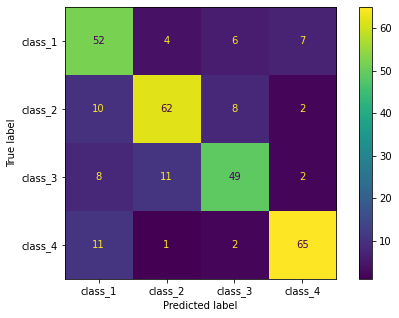

In [248]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

# Build a synthetic dataset
X, y = make_classification(
    n_samples=1000, n_features=5, n_informative=4, n_redundant=1, n_classes=4
)

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1121218
)

# Fit/predict
etc = ExtraTreesClassifier()
_ = etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3", "class_4"],
)

cmp.plot(ax=ax)
plt.show();

We will focus on multiclass confusion matrices later in the tutorial.

### Binary classifiers that support mutliclass classification with One-vs-One strategy

Other supervised classification algorithms were mainly designed for binary case. However, Sklearn implements two strategies called One-vs-One (OVO) and One-vs-Rest (OVR, also called One-vs-All) to convert a multi-class problem into a series of binary tasks. 

OVO splits a multi-class problem into a single binary classification task for each pair of classes. In other words, for each pair, a single binary classifier will be built. For example, for a target with 4 classes - brain, lung, breast and kidney cancer:

- Classifier 1: lung vs breast
- Classifier 2: lung vs kidney
- Classifier 3: lung vs brain
- Classifier 4: breast vs kidney
- Classifier 5: breast vs brain
- Classifier 6: kidney vs brain

Sklearn suggests these classifiers to work best with OVO approach:

- [svm.NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC)
- [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [gaussian_process.GaussianProcessClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier) (setting multi_class = “one_vs_one”)

Sklearn also provides a wrapper estimator for the above models under `sklearn.multiclass.OneVsOneClassifier`:

In [249]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# Don't have to set `multi_class` argument if used with OVOClassifier
ovo = OneVsOneClassifier(estimator=GaussianProcessClassifier())

ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=GaussianProcessClassifier())

A major downside of this strategy is its computation workload. As each pair of classes require a separate binary classifier, targets with high cardinality may take too long to train. To compute the number of classifiers built for N-class problem, the following formula is used:

![](./images/1.png)

In [250]:
# Print the number of estimators created
print(len(ovo.estimators_))

6


In practice, One-vs-Rest strategy is much preferred because of this disadvantage.

2. One-vs-All or One-vs-Rest (OVR). For N-class classification problem, this strategy creates N number of binary classifiers, one for each class. For the cancer example with 4 target classes:
- Classifier 1: lung vs \[breast, kidney, brain\]
- Classifier 2: breast vs \[lung, kidney, brain\]
- Classifier 3: kidney vs \[lung, breast, brain\]
- Classifier 4: brain vs \[lung, breast kidney\]

In the first problem, Sklearn treats lung class as the positive and encodes it as 1 and the rest of class gets converted to 0s. The same pattern continues for all classes in N-class problem.

Its implementation in Sklearn can be found under `sklearn.multiclass`. Here is an example of OVR on our synthetic dataset:

In [19]:
from sklearn.multiclass import OneVsRestClassifier

# Init/fit
clf = OneVsRestClassifier(estimator=LogisticRegression())
_ = clf.fit(X, y)

In [20]:
clf.estimators_

[LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression()]

> The estimator passed to OVR or OVO should implement `fit` method and either of `predict_proba` or `decision_function` methods.

Even though this strategy significantly lowers the computational cost, the fact that only one class is considered positive and the rest negative makes each binary problem an *imbalanced classification*. This problem is even more pronounced for classes with low proportions in the target.

In both approaches, depending on the passed estimator, the results of all binary classifiers can be summarized in two ways:
- majority of the vote: each binary classifier predicts one class and the class that got the most votes from all classifiers is chosen
- depending on the argmax of class membership probability scores: classifiers such as LogisticRegression computes probability scores for each class (`.predict_proba()`). Then, the argmax of the sum of the scores is chosen.

Note that tree-based and ensemble models support multi-class classification natively. So, there is no need to wrap them either in OVO or OVR. However, regardless of model type, these strategies are still essential when we are talking about the evaluation metrics in the coming sections.

### Sample classification problem and preprocessing pipeline

We will be predicting the quality of diamonds using the [Diamonds dataset](https://www.kaggle.com/shivam2503/diamonds) from Kaggle:

In [22]:
import pandas as pd

diamonds = pd.read_csv("data/diamonds.csv").drop("Unnamed: 0", axis=1)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [24]:
diamonds.shape

(53940, 10)

In [25]:
diamonds.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.798,0.474,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749,1.433,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457,2.234,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.800,3989.440,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731,1.122,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.735,1.142,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.539,0.706,0.0,2.91,3.53,4.04,31.80


The above output shows the features are on different scales which suggest we use some type of normalization. This step is essential for many linear-based models.

In [23]:
diamonds.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

The dataset contains a mixture of numeric and categorical features. I covered preprocessing steps for binary classification in my [last article](https://towardsdatascience.com/how-to-tune-models-like-a-puppet-master-based-on-confusion-matrix-fd488f9b5e65?source=your_stories_page-------------------------------------) in detail. The ideas can be easilty applied to multi-class case, so, I will keep the explanations here nice and short. 

The target is 'cut' which has 5 classes: Ideal, Premium, Very Good, Good, and Fair (descending quality). We will encode the textual features with OneHotEncoder. Let's take a quick look at the distributions of each numeric feature to decide what type of normalization to use:

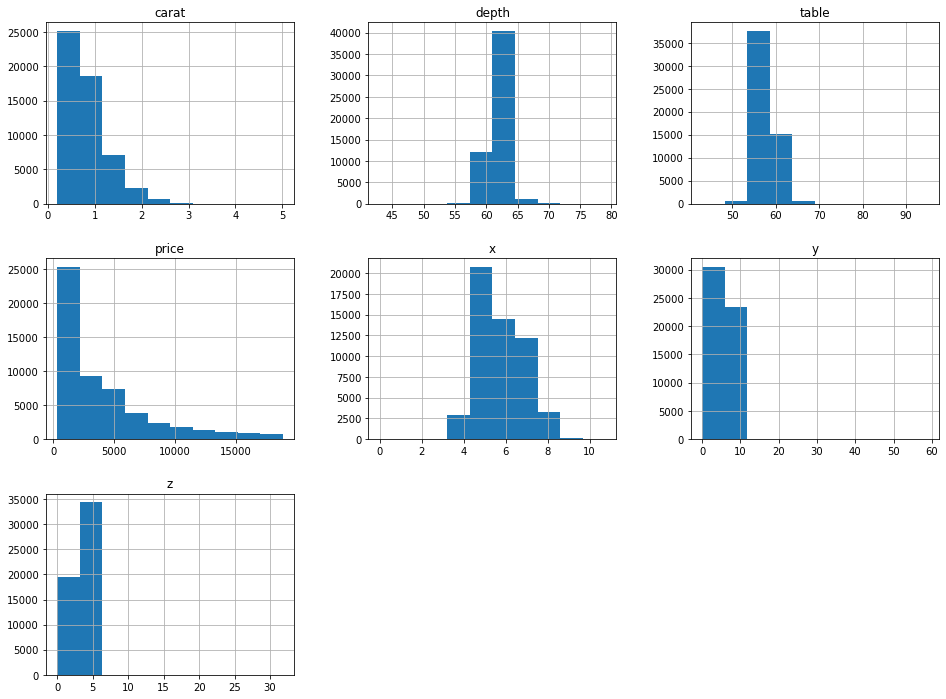

In [27]:
diamonds.hist(figsize=(16, 12));

Price and carat shows skewed distributions. We will use a logarithmic transformer to make them as normally-distributed as possible. For the rest, simple standardization is enough. If you are not familiar with numeric transformations, check out my [article](https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94?source=your_stories_page-------------------------------------) on the topic. Also, below code contains an example of Sklearn pipelines and you can learn all about them from [here](https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d?source=your_stories_page-------------------------------------). Let's get to work:

In [241]:
from sklearn.model_selection import train_test_split

# Build feature/target arrays
X, y = diamonds.drop("cut", axis=1), diamonds["cut"].values.flatten()

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1121218, test_size=0.33, stratify=y
)

In [242]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

# Build categorical preprocessor
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))


# Build numeric processor
to_log = ["price", "carat"]
to_scale = ["x", "y", "z", "depth", "table"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Full processor
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale),
    ]
)

# Final pipeline combined with LogReg
logreg_pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "logreg",
            RandomForestClassifier(max_depth=13),
        ),
    ]
)

In [230]:
_ = logreg_pipeline.fit(X_train, y_train)

In [231]:
logreg_pipeline.score(X_train, y_train)

0.7592628462326019

In [232]:
logreg_pipeline.score(X_test, y_test)

0.6851300488736588

In [233]:
preds = logreg_pipeline.predict(X_test)

In [234]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78       532
           1       0.87      0.50      0.63      1619
           2       0.82      0.92      0.87      7112
           3       0.73      0.77      0.75      4551
           4       0.76      0.25      0.38      3987

   micro avg       0.79      0.69      0.73     17801
   macro avg       0.82      0.62      0.68     17801
weighted avg       0.79      0.69      0.70     17801
 samples avg       0.69      0.69      0.69     17801



C:\Users\User\anaconda3\envs\medium_articles\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [235]:
from sklearn.metrics import roc_auc_score

In [237]:
logreg_pipeline.predict_proba(X_test)

[array([[9.99399012e-01, 6.00988119e-04],
        [9.77496189e-01, 2.25038108e-02],
        [9.94674117e-01, 5.32588328e-03],
        ...,
        [9.99957426e-01, 4.25737623e-05],
        [9.99408064e-01, 5.91935897e-04],
        [9.99774069e-01, 2.25930772e-04]]),
 array([[0.99645652, 0.00354348],
        [0.98237025, 0.01762975],
        [0.96559814, 0.03440186],
        ...,
        [0.99797703, 0.00202297],
        [0.9824579 , 0.0175421 ],
        [0.99596984, 0.00403016]]),
 array([[0.25103707, 0.74896293],
        [0.29621303, 0.70378697],
        [0.87060916, 0.12939084],
        ...,
        [0.11052693, 0.88947307],
        [0.23643423, 0.76356577],
        [0.13050294, 0.86949706]]),
 array([[0.86939375, 0.13060625],
        [0.84301751, 0.15698249],
        [0.41460247, 0.58539753],
        ...,
        [0.96545616, 0.03454384],
        [0.94401767, 0.05598233],
        [0.94878479, 0.05121521]]),
 array([[0.88371365, 0.11628635],
        [0.90090302, 0.09909698],
        

In [238]:
logreg_pipeline.classes_

[array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]

In [240]:
roc_auc_score(
    y_test,
    logreg_pipeline.predict_proba(X_test)[:, 0],
    multi_class="ovr",
    average="macro",
)

TypeError: list indices must be integers or slices, not tuple

In [223]:
y_train.shape

(36139,)

In [227]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

temp = lb.fit_transform(y)

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])